In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage.filters import gaussian_filter

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1BkKZ8truYRIscDmhKpMY_xWYt5o-7mtRwUFbdz92IKs/pub?w=960&h=720"> </td></tr>
</table>


Content image: (1, 400, 499, 3) -123.68 151.061
  Style image: (1, 400, 499, 3) -123.68 151.061


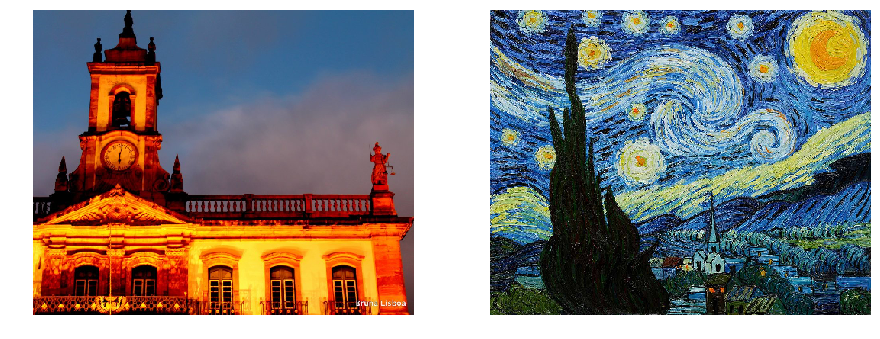

In [3]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)

image_file_path = figdir + 'museu_by_bruna.png'
# image_file_path = figdir + 'lavras_novas__bruna.png'

style_file_path = figdir + 'tolouse- lautrec.png'
style_file_path = '../../images/van_gogh_3.jpg'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print('Content image:', vgg_image.shape, vgg_image.min(), vgg_image.max())
print('  Style image:', vgg_style.shape, vgg_style.min(), vgg_style.max())

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(vgg_image[0]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(vgg_style[0]))
plot.axis('off');


In [4]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

In [5]:
def compute_content_loss(base, output):
    """
    Feature reconstruction loss function. Encourages the 
    output img to be perceptually similar to the base image.
    """
    return K.sum(K.square(output - base))

def gram_matrix(x):
    """
    Computes the outer-product of the input tensor x.
    Note that this can be computed efficiently if x is reshaped
    as a tensor of shape (C x H*W).
    """
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

def compute_style_loss(base, output, img_nrows, img_ncols):
    """
    Style reconstruction loss. Encourage the output img 
    to have same stylistic features as style image. Does not
    preserve spatial structure however.
    """
    H, W, C = img_nrows, img_ncols, 3
    gram_base = gram_matrix(base)
    gram_output = gram_matrix(output)
    factor = 1.0 / float((2*C*H*W)**2)
    out = factor * K.sum(K.square(gram_output - gram_base))
    return out

def total_variation_loss(x, img_nrows, img_ncols):
    """
    Total variational loss. Encourages spatial smoothness 
    in the output image.
    """
    H, W = img_nrows, img_ncols
    a = K.square(x[:, :H-1, :W-1, :] - x[:, 1:, :W-1, :])
    b = K.square(x[:, :H-1, :W-1, :] - x[:, :H-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [6]:
class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        # self.loss, self.grad_values = self.funct([x.reshape(self.shape)])
        (self.loss, 
         self.content_loss, 
         self.style_loss, 
         self.variation_loss, 
         self.grad_values) = self.funct([x.reshape(self.shape)])
        return self.loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

def my_solver(obj, x, niter=10, prefix=None, interval=1):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            dt = time.time() - t0
            if i%interval == 0:
                # print('{:2d}. loss: {:.3e} {:.3f}s'.format(i, min_val, dt))
                print('{:2d}. loss: {:.3e} [{:.3e} + {:.3e} + {:.3e}] {:.3f}s'.format(i, min_val, 
                                                                                      obj.content_loss,
                                                                                      obj.style_loss,
                                                                                      obj.variation_loss,
                                                                                      dt))
                if prefix is not None:
                    imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(x))
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images  

In [7]:
vgg_output_dict = {layer.name: layer.output for layer in vgg.layers}

In [8]:
content_output = vgg_output_dict['block5_conv1']
content_model = Model(vgg.input, content_output)
content_target = K.variable(content_model.predict(vgg_image))
content_loss = compute_content_loss(content_output, content_target)

In [9]:
style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
style_outputs = [vgg_output_dict['block{}_conv1'.format(o)] for o in range(1,6)]
style_model = Model(vgg.input, style_outputs)
style_targets = [K.variable(o) for o in style_model.predict(vgg_style)]
style_loss = sum(w * compute_style_loss(out[0], targ[0], img_nrows, img_ncols) for out, targ, w in zip(style_outputs, 
                                                                                                       style_targets, 
                                                                                                       style_weights))

In [10]:
variation_loss = total_variation_loss(vgg.input, img_nrows, img_ncols)

In [11]:
content_weight = 5
style_weight = 1
tv_weight = 1

total_loss = content_weight * content_loss + \
             style_weight * style_loss +     \
             tv_weight * variation_loss

grads = K.gradients(total_loss, vgg.input)
# fn = K.function([vgg.input], [total_loss] + grads)
fn = K.function([vgg.input], [total_loss, content_loss, style_loss, variation_loss] + grads)

In [12]:
x = np.random.uniform(0.0, 255.0, vgg_image.shape) - 128.0
A = my_solver(Evaluator(fn, vgg_image.shape), x, niter=101, interval=5)

 0. loss: 4.870e+10 [4.716e+09 + 8.827e+09 + 1.629e+10] 8.720s
 5. loss: 1.559e+10 [1.302e+09 + 3.007e+09 + 6.078e+09] 7.421s
10. loss: 1.330e+10 [1.056e+09 + 2.678e+09 + 5.339e+09] 7.504s
15. loss: 1.254e+10 [9.753e+08 + 2.594e+09 + 5.069e+09] 7.517s
20. loss: 1.218e+10 [9.349e+08 + 2.571e+09 + 4.937e+09] 7.515s
25. loss: 1.200e+10 [9.148e+08 + 2.554e+09 + 4.868e+09] 7.544s
30. loss: 1.187e+10 [9.020e+08 + 2.545e+09 + 4.819e+09] 7.633s
35. loss: 1.179e+10 [8.936e+08 + 2.537e+09 + 4.789e+09] 7.597s
40. loss: 1.174e+10 [8.876e+08 + 2.534e+09 + 4.766e+09] 7.604s
45. loss: 1.170e+10 [8.834e+08 + 2.528e+09 + 4.751e+09] 7.624s
50. loss: 1.166e+10 [8.801e+08 + 2.526e+09 + 4.738e+09] 7.625s
55. loss: 1.164e+10 [8.778e+08 + 2.523e+09 + 4.730e+09] 7.586s
60. loss: 1.162e+10 [8.755e+08 + 2.522e+09 + 4.722e+09] 7.591s
65. loss: 1.160e+10 [8.736e+08 + 2.520e+09 + 4.716e+09] 7.630s
70. loss: 1.159e+10 [8.718e+08 + 2.519e+09 + 4.709e+09] 7.647s
75. loss: 1.157e+10 [8.702e+08 + 2.517e+09 + 4.705e+09]

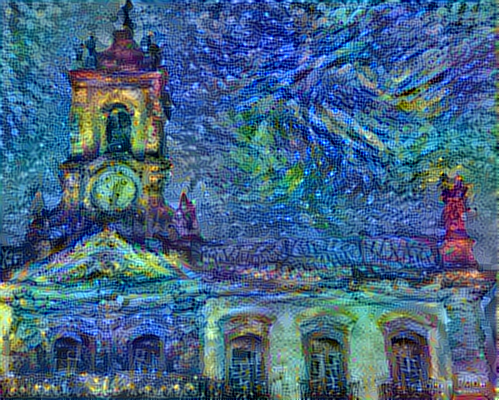

In [13]:
array_to_img(deprocess_image(A[-1]))

In [14]:
A = my_solver(Evaluator(fn, vgg_image.shape), vgg_image, niter=26, interval=5)

 0. loss: 2.738e+10 [2.053e+09 + 9.311e+09 + 7.809e+09] 7.388s
 5. loss: 1.294e+10 [8.803e+08 + 3.442e+09 + 5.093e+09] 7.513s
10. loss: 1.169e+10 [7.791e+08 + 3.036e+09 + 4.755e+09] 7.552s
15. loss: 1.121e+10 [7.417e+08 + 2.883e+09 + 4.616e+09] 7.537s
20. loss: 1.096e+10 [7.212e+08 + 2.809e+09 + 4.542e+09] 7.529s
25. loss: 1.081e+10 [7.091e+08 + 2.768e+09 + 4.498e+09] 7.623s


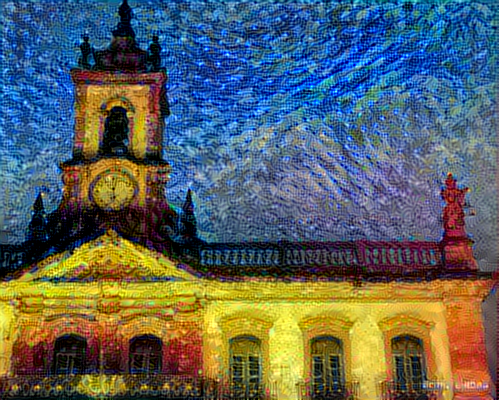

In [15]:
array_to_img(deprocess_image(A[-1]))